View this notebook on [nbviewer](https://nbviewer.jupyter.org/urls/gitlab.com/BinCheng/random-quantum-circuit/raw/master/qtorch-test.ipynb).

In [1]:
import numpy as np

In [2]:
import qutip as qt

In [3]:
from matplotlib import *
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
from matplotlib.ticker import MaxNLocator # display integers in the x/y axis

In [6]:
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
from time import clock

In [8]:
pi = np.pi
e = np.e

In [9]:
x = qt.sigmax()

In [10]:
def Circuit(n,d):  # generate the circuit randomly
    circuit = {}
    count = 0
    
    for m in range(n):
        count += 1
        circuit[count] = ['H', m] # the first layer of Hadamard gates
    
    for m in range(d):
        for m1 in range(n):
            count += 1
            indicator = np.random.choice(3)
            if indicator == 0:
                circuit[count] = ["H",m1] # Hadamard acting on the m1-th qubit
            elif indicator == 1:
                circuit[count] = ["T",m1]  # T-gate acting on the m1-th qubit
            else: # note that n has to be greater than 1
                if m1 == n-1:
                    circuit[count] = ["CZ",n-2,n-1] # CZ acting on the (n-1)-th and (n-2)-th qubit
                else:
                    circuit[count] = ["CZ",m1,m1+1] # CZ acting on the m1-th and (m1 + 1)-th qubit
    return circuit

In [20]:
n = 25 # number of qubits. n has to be greater than 1
d = n # depth

In [21]:
circuit = Circuit(n,d) # generate the circuit
#circuit

In [22]:
init = np.zeros(n)
init

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [23]:
final = np.random.choice(2,n) # intended output state
final

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1])

In [24]:
with open("test/test_%d.txt" %n, "w+") as f: # write measurement file
    for m in final:
        f.write("%d " %m)

In [25]:
with open("test/test_%d.qasm" %n,'w+', newline = "\n") as f: # write qasm file
    f.write("%d\n" %n )
    f.write("def1 T /qtorch-test/gates/t.gate\n")
    f.write("def2 CZ /qtorch-test/gates/cz.gate\n")

In [26]:
with open("test/test_%d.qasm" %n, "a+", newline = "\n") as f: # write qasm file, text mode
    for m in range(n*d+n):
        for m1 in circuit[m+1]:
            f.write("%s " %m1)
        f.write("\n")
#    for m in range(n-1):
#        f.write("CZ %s " %m)
#        f.write("%s\n" %(m+1))
#        f.write("CZ %s " %m)
#        f.write("%s\n" %(m+1))

In [27]:
with open("test/test_%d.inp" %n, "w+") as f: # write input script
    f.write("# Line graph decomposition method for contraction\r\n")
    f.write(">int threads %d\r\n" %n)
    f.write(">string qasm /qtorch-test/test/test_%d.qasm\r\n" %n)
    f.write(">string measurement /qtorch-test/test/test_%s.txt\r\n" %n)
    f.write(">string contractmethod linegraph-qbb\r\n")
    f.write(">int quickbbseconds 5\r\n")
    f.write(">string outputpath /qtorch-test/test/test.out\r\n")

## Verification

In [782]:
# generate initial state
up = qt.basis(2,0) # |0>
for m in range(n):
    if m == 0:
        initQ = x**(init[m])*up
        finalq = x**(final[m])*up
        continue
    initQ = qt.tensor(initQ, x**(init[m])*up)
    finalq = qt.tensor(finalq, x**(final[m])*up)

In [783]:
%%time
finalQ = initQ

for m in range(n*d+n):
    gate = circuit[m+1][0]
    if gate == 'H':
        finalQ = qt.snot(n,circuit[m+1][1])*finalQ
    elif gate == 'T':
        finalQ = qt.phasegate(pi/4,n,circuit[m+1][1])*finalQ
    else:
        finalQ = qt.csign(n,circuit[m+1][1],circuit[m+1][2])*finalQ

Wall time: 235 ms


In [784]:
abs((finalq.dag()*finalQ)[0,0])**2

0.0045025361707580636

In [ ]:
finalQ

___

In [15]:
N = []
for m in range(21):
    if m < 2:
        continue
    N.append(m)

In [11]:
qutip_avg = [0.013266667,0.016633333,0.022866667,0.0345,\
             0.091866667,0.0666,0.1737,0.162333333,\
             0.236666667,0.340333333,0.469333333,\
             0.904666667,2.276666667,4.473333333,\
             8.923333333,18.91666667,50.2,109.6666667,267]

In [12]:
qtorch_avg = [0.00634,0.0099,0.0132,0.0139,0.0251,0.0167,\
             0.0333,0.855,1.8,0.198,1.987,4.89,3.16,5.3,\
             5.06,7.42,5.28,5.97,17.36]

In [13]:
width = [3,3,3,3.33,4.33,3.67,4,4.67,5.33,5.33,6,6.67,6,\
        7.67,7.67,9,7.67,8.33,9.67]

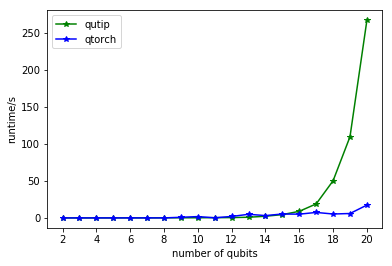

In [17]:
pp = PdfPages('images/qtorch-qutip.pdf')
fig, ax = plt.subplots()
ax.plot(N,qutip_avg,"g*-",label="qutip")
ax.plot(N,qtorch_avg,"g*-",label="qtorch",color="blue")
ax.legend(loc=0)
ax.set_xlabel('number of qubits')
ax.set_ylabel('runtime/s')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
pp.savefig(fig)
pp.close()

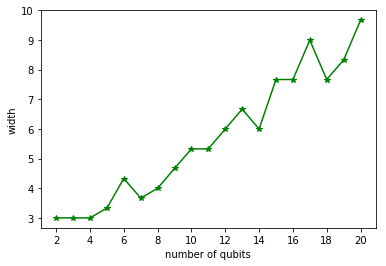

In [18]:
pp = PdfPages('images/width.pdf')
fig, ax = plt.subplots()
ax.plot(N,width,"g*-")
ax.set_xlabel('number of qubits')
ax.set_ylabel('width')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
pp.savefig(fig)
pp.close()

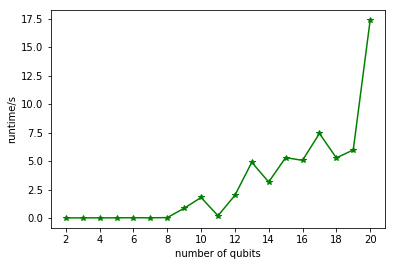

In [19]:
pp = PdfPages('images/qtorch.pdf')
fig, ax = plt.subplots()
ax.plot(N,qtorch_avg,"g*-", label = "qtorch")
ax.set_xlabel('number of qubits')
ax.set_ylabel('runtime/s')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
pp.savefig(fig)
pp.close()